# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 

## Import Packages

In [1]:
import cv2
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os

from PIL import Image

%matplotlib inline

## Helper Functions

In [2]:
def grayscale(img):
    """Applies the Grayscale transform"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    """
    # defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    # filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    if lines:
        for line in lines:
            for x1,y1,x2,y2 in line:
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def average_and_extrapolate_line(lines,img_shape):
    # average
    x1m = int(np.mean([l[0] for l in lines[0]]))
    y1m = int(np.mean([l[1] for l in lines[0]]))
    x2m = int(np.mean([l[2] for l in lines[0]]))
    y2m = int(np.mean([l[3] for l in lines[0]]))
    
    # extrapolate
    y_top = img_shape[0]//2 + img_shape[0]//10
    x_top = int((x2m-x1m)*(y_top-y1m)/(y2m-y1m)+x1m)
    
    y_bottom = img_shape[0]
    x_bottom = int((x2m-x1m)*(y_bottom-y1m)/(y2m-y1m)+x1m)
    
    return [[[x_top,y_top,x_bottom,y_bottom]]]
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, filter_lines=None):
    """
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    if filter_lines and lines is not None and len(lines)>0:
        lines = list(filter(filter_lines, lines))

    # Average lines
    if lines and len(lines)>0:
        draw_lines(line_img, average_and_extrapolate_line(lines,img.shape), thickness=5)
    
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

### Lane Finding Pipeline



In [3]:
# Region of interest

def get_mask_vertices_left(image):
    maxy, maxx, _ = image.shape
    lower_by = maxy//10
    shift_by = maxy//8
    shift_by_bottom = maxy//16
    mask_vertices = np.array([[
                            (shift_by_bottom, maxy),
                            (maxx//2-shift_by, maxy//2+lower_by), 
                            (maxx//2, maxy//2+lower_by), 
                            (maxx//2, maxy)]], dtype=np.int32)
    return mask_vertices

def get_mask_vertices_right(image):
    maxy, maxx, _ = image.shape
    lower_by = maxy//10
    shift_by = maxy//8
    shift_by_bottom = maxy//16
    mask_vertices = np.array([[
                            (maxx//2, maxy),
                            (maxx//2, maxy//2+lower_by), 
                            (maxx//2+shift_by, maxy//2+lower_by), 
                            (maxx-shift_by_bottom, maxy)]], dtype=np.int32)
    return mask_vertices

In [4]:
# Method used for filtering houhg lines
slope_margin = 0.5
min_slope_left = -1 - slope_margin
max_slope_left = -1 + slope_margin
min_slope_right = 1 - slope_margin
max_slope_right = 1 + slope_margin

def filter_lines_left(line):
    x1,y1,x2,y2 = line[0]
    slope = (y2-y1)/(x2-x1)
    return (slope >= min_slope_left and slope <= max_slope_left) 

def filter_lines_right(line):
    x1,y1,x2,y2 = line[0]
    slope = (y2-y1)/(x2-x1)
    return (slope >= min_slope_right and slope <= max_slope_right) 

In [5]:
# Main finding lane pipeline
def find_lanes(img):
    img_blur = gaussian_blur(img, 7)

    img_canny_r = canny(img_blur[:,:,0], 50, 100)
    img_canny_g = canny(img_blur[:,:,1], 50, 100)
    img_canny_b = canny(img_blur[:,:,2], 50, 100)
    
    img_canny = np.maximum(img_canny_r, img_canny_g)
    img_canny = np.maximum(img_canny, img_canny_b)
    
    # Left side
    mask_vertices_left = get_mask_vertices_left(img)
    img_roi_left = region_of_interest(img_canny, mask_vertices_left)
    img_hough_left = hough_lines(img_roi_left, 2, math.pi/180, 10, 40, 20, filter_lines=filter_lines_left)
    
    # Right side
    mask_vertices_right = get_mask_vertices_right(img)
    img_roi_right = region_of_interest(img_canny, mask_vertices_right)
    img_hough_right= hough_lines(img_roi_right, 2, math.pi/180, 10, 40, 20, filter_lines=filter_lines_right)
    
    # Merge sides
    img_hough = img_hough_left
    img_hough[:,img.shape[1]//2:,:] = img_hough_right[:,img.shape[1]//2:,:]
    
    return weighted_img(img_hough, img)

## Run on test images

In [6]:
!mkdir test_images_output

mkdir: test_images_output: File exists


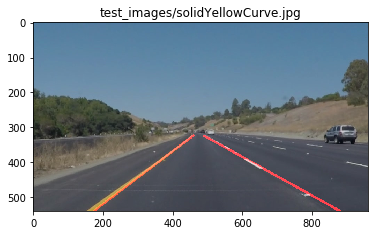

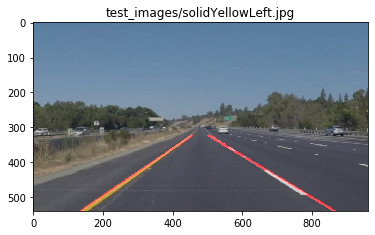

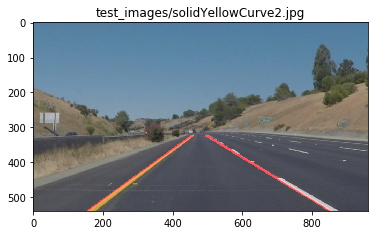

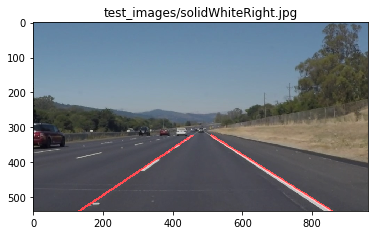

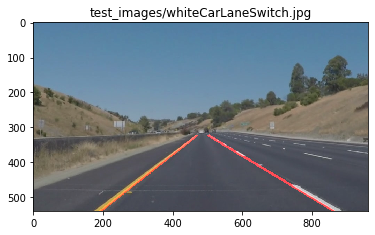

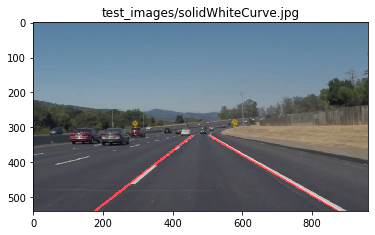

In [7]:
test_images = ["test_images/"+f for f in os.listdir("test_images/")]
# Testing method on sample image

for image_path in test_images:
    image = mpimg.imread(image_path)
    image_with_lanes = find_lanes(image)
    cv2.imwrite(image_path.replace('test_images','./test_images_output'), cv2.pyrDown(image_with_lanes[:,:,::-1]))
    plt.figure()
    plt.title(image_path)
    plt.imshow(image_with_lanes)

##### Test on Videos

In [8]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [9]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(find_lanes) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   2%|▏         | 5/221 [00:00<00:04, 48.83it/s, now=None]

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
CPU times: user 4.3 s, sys: 392 ms, total: 4.7 s
Wall time: 7.94 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [11]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(find_lanes)
%time yellow_clip.write_videofile(yellow_output, audio=False)

t:   1%|          | 6/681 [00:00<00:12, 55.06it/s, now=None]

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
CPU times: user 13 s, sys: 987 ms, total: 14 s
Wall time: 19.2 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [13]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(find_lanes)
%time challenge_clip.write_videofile(challenge_output, audio=False)

t:   2%|▏         | 4/251 [00:00<00:06, 39.42it/s, now=None]

Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
CPU times: user 9.45 s, sys: 692 ms, total: 10.1 s
Wall time: 16.1 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

## Optional Challenge: solution

Thie issue with challenge vide was that grayscaled image was loosing left yellow lane when road brightness changes. 
The solution was to find other color transformation that will preserve yellow lane difference. 
All RGB channels store different information about the color - applying canny to all of them an then merging result from 3 channels fixed 'dissappearing lane recognition'